# AutoEncoders

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sns.set()

# Check if MPS is available
print("MPS available:", torch.backends.mps.is_available())

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Computation device:", device)

MPS available: True
Computation device: mps


## Loading Data

In [2]:
# loading data
df = pd.read_csv("./data/augmented_data.csv")
# here we can remove the negative interactions since autoencoders will try to rebuild the whole vector
df = df[df["interaction"] == 1].reset_index(drop=True)
df.head()

,user_id,song_id,freq,artist,title,interaction
0,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOMWTWK12AB01860CD,2.0,Vampire Weekend,White Sky,1
1,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOBKRVG12A8C133269,1.0,Vampire Weekend,I Stand Corrected (Album),1
2,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOXFXDH12A8C13326E,1.0,Vampire Weekend,The Kids Dont Stand A Chance (Album),1
3,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOAYETG12A67ADA751,1.0,MIKA,Grace Kelly,1
4,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOUFNSM12A58A77715,1.0,Vampire Weekend,Walcott (Album),1


In [3]:
# Create categorical mappings
user_to_idx = {uid: idx for idx, uid in enumerate(df["user_id"].unique())}
song_to_idx = {sid: idx for idx, sid in enumerate(df["song_id"].unique())}

# Add numerical indices to the dataframe
df["user_idx"] = df["user_id"].map(user_to_idx)
df["song_idx"] = df["song_id"].map(song_to_idx)

df

,user_id,song_id,freq,artist,title,interaction,user_idx,song_idx
0,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOMWTWK12AB01860CD,2.0,Vampire Weekend,White Sky,1,0,0
1,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOBKRVG12A8C133269,1.0,Vampire Weekend,I Stand Corrected (Album),1,0,1
2,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOXFXDH12A8C13326E,1.0,Vampire Weekend,The Kids Dont Stand A Chance (Album),1,0,2
3,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOAYETG12A67ADA751,1.0,MIKA,Grace Kelly,1,0,3
4,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOUFNSM12A58A77715,1.0,Vampire Weekend,Walcott (Album),1,0,4
...,...,...,...,...,...,...,...,...
151159,07f2f354a2a4390624e0d04e4a555ef67e98f673,SODPPBT12A8C141D90,9.0,Kings Of Leon,Closer,1,11211,133
151160,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOEMRIK12A8C133722,4.0,Radiohead,Jigsaw Falling Into Place,1,11211,1011
151161,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOUSOOB12A8C13371F,6.0,Radiohead,House Of Cards,1,11211,1338
151162,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOWCKVR12A8C142411,4.0,Kings Of Leon,Use Somebody,1,11211,69


In [4]:
# let's get the number of users and songs
n_users = df["user_id"].nunique()
n_songs = df["song_id"].nunique()

print(f"Number of users: {n_users}, number of songs: {n_songs}")


Number of users: 11212, number of songs: 2000


In [5]:
# split data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.head()

,user_id,song_id,freq,artist,title,interaction,user_idx,song_idx
1307,90d506afcd30ea734e6e629dbb84ec058f226d02,SOOXLND12A6D4FE36E,1.0,Fleetwood Mac,Go Your Own Way (LP Version),1,93,688
20746,38f022b1b31eda3002f992b997130a9d23209563,SOHGBHN12A6701F082,1.0,Jack Johnson,Taylor,1,1512,1214
131161,f32f163b46ce7087fa123b94a0baa2667b406b58,SODJWHY12A8C142CCE,5.0,Train,Hey_ Soul Sister,1,9732,74
149838,0225648099019b3f6b99182de7b00feac1168115,SOTKYBW12A8C13C3EA,6.0,Bon Iver,Skinny Love,1,11114,680
52425,6b664561bc67f393cf6d5fffa2dd3b644197698f,SOQGJZA12A8C1367AE,2.0,Katy Perry,Thinking Of You,1,3861,1629


In [6]:
class MusicDataset(Dataset):
    def __init__(self, df, n_users, n_songs):
        self.interactions = torch.zeros((n_users, n_songs))

        # Fill the interaction matrix
        for _, row in df.iterrows():
            self.interactions[row["user_idx"], row["song_idx"]] = row["interaction"]

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        return self.interactions[idx]

In [7]:
# Create datasets and dataloaders
train_dataset = MusicDataset(train_df, n_users, n_songs)
test_dataset = MusicDataset(test_df, n_users, n_songs)

In [8]:
# dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Model

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, n_songs, latent_dim=100):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_songs, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.Dropout(0.5),
            nn.ReLU(),
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, n_songs),
        )

    def forward(self, x):
        # encoder pass
        latent = self.encoder(x)
        # decoder pass
        reconstructed = self.decoder(latent)
        return reconstructed

    def get_latent(self, x):
        return self.encoder(x)

In [10]:
# Initialize model
model = AutoEncoder(n_songs).to(device)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=2000, bias=True)
  )
)

In [11]:
next(iter(train_loader))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [12]:
# trying to pass data to the model to see if it works
user_batch = next(iter(train_loader))
# moving to device
user_batch = user_batch.to(device)
# passing data to the model
pred = model(user_batch)
pred.shape


torch.Size([64, 2000])

## Training model


In [13]:
# hyperparameters
EPOCHS = 10
K = 100  # latent dimensionality
REG_LAMBDA = 1e-6  # some regularization

In [14]:
# Initialize model
model = AutoEncoder(n_songs, K).to(device)
model

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# we want to penalize the loss only for the non-zero elements
def custom_loss(y_pred, y_true):
    # mask of 0s and 1s
    mask = (y_true != 0).float()
    # BCEWithLogitsLoss
    bce = nn.BCEWithLogitsLoss(reduction="none")(y_pred, y_true)
    # Apply mask
    masked_bce = bce * mask

    # Add L2 regularization
    l2_reg = 0
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)

    base_loss = torch.sum(masked_bce) / (torch.sum(mask) + 1e-6)
    return base_loss + REG_LAMBDA * l2_reg

In [16]:
# Training loop
train_losses = []
test_losses = []
best_test_loss = float("inf")

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        batch = batch.to(device)

        # Forward pass
        output = model(batch)
        loss = custom_loss(output, batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluation - using train data as input but comparing against test data since autoencoder try to recreate its input!
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for train_batch, test_batch in zip(train_loader, test_loader):
            train_batch = train_batch.to(device)
            test_batch = test_batch.to(device)

            # Get reconstruction from training data
            output = model(train_batch)

            # Compare against test data
            loss = custom_loss(output, test_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print("-" * 50)

Epoch 1/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.3016
Test Loss: 0.1507
--------------------------------------------------


Epoch 2/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.0556
Test Loss: 0.0571
--------------------------------------------------


Epoch 3/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.0192
Test Loss: 0.0281
--------------------------------------------------


Epoch 4/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.0096
Test Loss: 0.0171
--------------------------------------------------


Epoch 5/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.0058
Test Loss: 0.0117
--------------------------------------------------


Epoch 6/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.0037
Test Loss: 0.0080
--------------------------------------------------


Epoch 7/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.0027
Test Loss: 0.0058
--------------------------------------------------


Epoch 8/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.0021
Test Loss: 0.0044
--------------------------------------------------


Epoch 9/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.0016
Test Loss: 0.0038
--------------------------------------------------


Epoch 10/10:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.0013
Test Loss: 0.0030
--------------------------------------------------


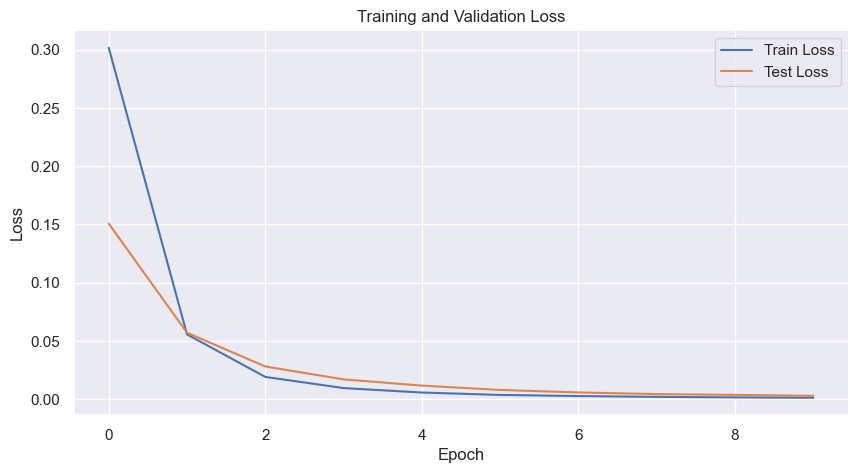

In [17]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## making predictions

In [18]:
sample_user_ids = [
    "05b9035fe02ebdf5535ae9ec07de1e935ffa43df",
    "4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5",
    "6530c4fc41b9110de5d39fe0355fa103c66385f0",
]
sample_user_ids

['05b9035fe02ebdf5535ae9ec07de1e935ffa43df',
 '4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5',
 '6530c4fc41b9110de5d39fe0355fa103c66385f0']

In [19]:
# sample song ids
sample_song_ids = df[df["user_id"].isin(sample_user_ids)]["song_id"].unique()[:5]
sample_song_ids

array(['SOMWTWK12AB01860CD', 'SOBKRVG12A8C133269', 'SOXFXDH12A8C13326E',
       'SOAYETG12A67ADA751', 'SOUFNSM12A58A77715'], dtype=object)

In [20]:
def get_recommendations(model, user_ids, k=3, device=device):
    # create user vectors
    user_vectors = []
    for user_id in user_ids:
        user_vector = torch.zeros(n_songs)
        user_songs = df[df["user_id"] == user_id]["song_idx"].values
        user_vector[user_songs] = 1
        user_vectors.append(user_vector)

    user_vectors = torch.stack(user_vectors).to(device)

    model.eval()
    with torch.no_grad():
        # Get predictions
        predictions = torch.sigmoid(model(user_vectors))

        # Move back to CPU for numpy operations
        predictions = predictions.cpu()

        # Set already listened songs to -inf
        predictions[user_vectors.cpu() > 0] = float("-inf")

        # Get top-k values and indices
        values, indices = torch.topk(predictions, k)

    # Create reverse mapping for song indices to IDs
    idx_to_song = {idx: sid for sid, idx in song_to_idx.items()}

    # Create recommendations dictionary
    recommendations = {}
    for i, user_id in enumerate(user_ids):
        user_recommendations = []
        for value, idx in zip(values[i], indices[i]):
            song_id = idx_to_song[idx.item()]
            artist = df[df["song_id"] == song_id]["artist"].iloc[0]
            title = df[df["song_id"] == song_id]["title"].iloc[0]
            song_name = f"{artist} - {title}"
            user_recommendations.append((song_name, value.item()))
        recommendations[user_id] = user_recommendations

    return recommendations

In [21]:
get_recommendations(model, sample_user_ids)

{'05b9035fe02ebdf5535ae9ec07de1e935ffa43df': [('Cartola - Tive Sim',
   0.999983549118042),
  ('Usher featuring will.i.am - OMG', 0.9999797344207764),
  ('Alliance Ethnik - Représente', 0.9999781847000122)],
 '4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5': [('Kid Cudi / MGMT / Ratatat - Pursuit Of Happiness (nightmare)',
   0.9999080896377563),
  ('Usher featuring will.i.am - OMG', 0.9998760223388672),
  ('Future Rock - Gears', 0.9998582601547241)],
 '6530c4fc41b9110de5d39fe0355fa103c66385f0': [('Train - Hey_ Soul Sister',
   0.9999678134918213),
  ('Lil Wayne / Eminem - Drop The World', 0.9999552965164185),
  ('Kid Cudi / MGMT / Ratatat - Pursuit Of Happiness (nightmare)',
   0.9999535083770752)]}

Here we can evaluate some recommendation for a hardcore fan of an artist

In [22]:
# get specific artist data
artist_df = df[(df.artist == "Eminem") & (df.interaction == 1)]

# Get users who listen to that artist and their total song count
user_total_songs = df[df.interaction == 1].groupby("user_id").size()
user_artist_songs = artist_df.groupby("user_id").size()

# Calculate ratio of artist songs to total songs per user
artist_ratio = pd.DataFrame(
    {"total_songs": user_total_songs, "artist_songs": user_artist_songs}
).fillna(0)
artist_ratio["ratio"] = artist_ratio["artist_songs"] / artist_ratio["total_songs"]
artist_ratio

,total_songs,artist_songs,ratio
user_id,,,
0003798d61a8010dbfd8010180b7107cbbb8a649,19,1.0,0.052632
00061a993bb3add5cc37b2ea28a9552337f2fe4d,16,0.0,0.000000
000a43eb37163bb2f93020e107a2d543f27257b7,11,0.0,0.000000
000ae9c80733348ff64cd3716a27477b94578d9d,10,0.0,0.000000
000dd7137b511a0c6e45880de551c6a7019ee4c3,10,0.0,0.000000
...,...,...,...
fff3b1ee05d9750e8868de9470ea46fcb0776f66,10,0.0,0.000000
fff4438f5d96c5ecd66678f2a22fd7bbed59625f,11,0.0,0.000000
fff5304527f3c658ce48cd7afa5b76b7b4172852,16,1.0,0.062500


In [23]:
# Find users with high artist ratio and a minimum number of artist songs
dedicated_fans = artist_ratio[
    (artist_ratio["ratio"] > 0.3) & (artist_ratio["artist_songs"] > 3)
].sort_values("ratio", ascending=False)
print("Top Eminem fans (by ratio of Eminem songs to total songs):")
print(dedicated_fans.head())

# extract top user id
user_id = dedicated_fans.index[0]


Top Eminem fans (by ratio of Eminem songs to total songs):
                                          total_songs  artist_songs     ratio
user_id                                                                      
1abe450971e4ea9fea6d1c48c36732bbfb2895dc           10           7.0  0.700000
73ad7d3f143b0d7ff5f7e0e1f0f07913e9943755           11           6.0  0.545455
4718c9a2a51067ab538fb460beefa0459002651c           10           5.0  0.500000
7ae393fd4e7e048fedfe228ca209ae44da21a3c6           10           5.0  0.500000
6c6083f4a8b1e0f6ef264203f5583c36628b3b94           10           5.0  0.500000


In [24]:
# get recommendations
recommendations = get_recommendations(model, [user_id], k=5, device=device)
recommendations


{'1abe450971e4ea9fea6d1c48c36732bbfb2895dc': [("O'Rosko Raricim - Terre Promise",
   0.9999798536300659),
  ('Cartola - Tive Sim', 0.9999738931655884),
  ("Dwight Yoakam - You're The One", 0.9999691247940063),
  ('Alliance Ethnik - Représente', 0.9999680519104004),
  ('Drake / Kanye West / Lil Wayne / Eminem - Forever', 0.9999659061431885)]}